In [ ]:
import ase
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import abtem

# nicer formatting for online display of pandas dataframes
pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.max_columns", 15)

abtem.config.set({"local_diagnostics.progress_bar": False})

# Mulitislice Simulations

### Plane waves

Komponenten zusammenführen -> d.h. z.b. ebene Welle mittels Mulitislice Algorithmus durch Probe mit definiertem Potential schicken

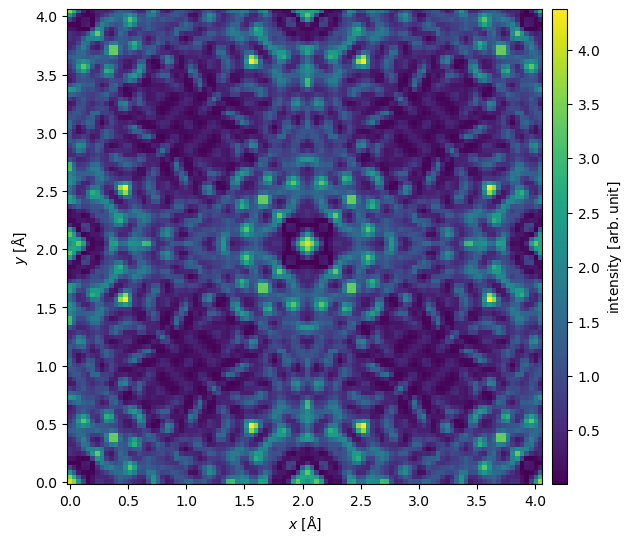

In [43]:
#preparation - building atom bulk & potential & wave
#Au -> naturally fcc structure!
unit_cell = ase.build.bulk("Au", cubic=True)#bulk, cubic -> builds cubic with Au atom on each edge. lattice constant = 4.08 A
atoms = unit_cell * (1, 1, 30)
potential = abtem.Potential(atoms, slice_thickness=4.08 / 2, sampling=0.04)# simulation cell now has a size of 4.08 x 4.08 x 122.4 A (~12 nm hoch)
plane_wave = abtem.PlaneWave(energy=200e3)

#applying multislice algorithm -> schneidet potential in Scheibchen; multislice method runs multisclice algorithm 
exit_wave = plane_wave.multislice(potential)
exit_wave.compute()
#exit_wave.shape

#plot
exit_wave.intensity().show(common_color_scale=True, cbar=True, figsize=(7,7))

In [82]:
#unit_cell.type() #unit_cell.name    unit_cell.cubic -> funktioniert alles nicht? __getattribute__(unit_cell, "name")

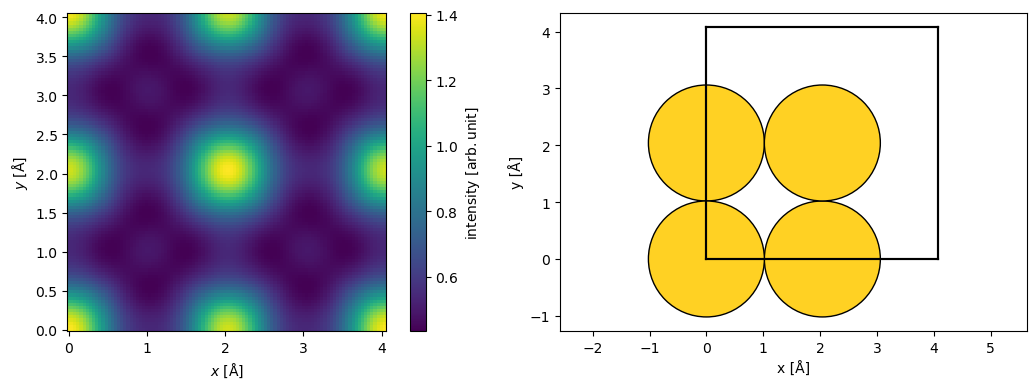

In [36]:
#abberations and cut-offs of large scattering angles are handeled via contrast transfer functions (see below)
#for now: defocus: -50, and objective aperture (Blendenöffnung) of 20 mrad [1 mrad = 0.057 Grad]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
exit_wave.apply_ctf(defocus=-50, semiangle_cutoff=20).intensity().show(cbar=True, ax=ax1)
abtem.show_atoms(atoms,plane='xy', ax=ax2, scale=0.75)

plt.tight_layout()

### Electron diffraction pattern

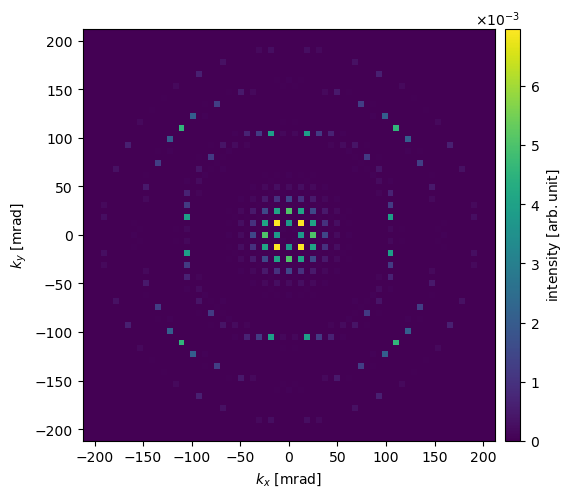

In [127]:
#check diffraction pattern
diffraction_pattern = exit_wave.diffraction_patterns()
diffraction_pattern.block_direct().show(units="mrad", cbar=True)#block_direct() blocks direct beam - intensity to high to show on same scale

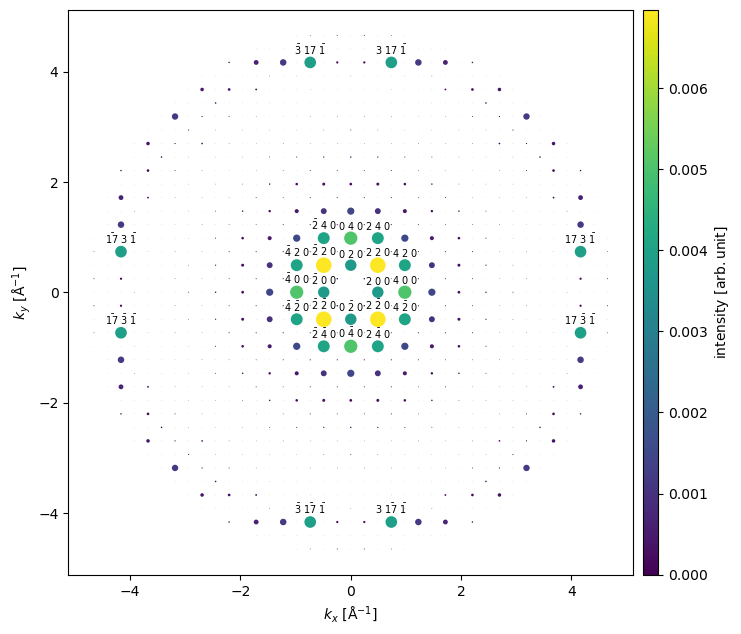

In [29]:
#Streubilder mit hkl-Indizes
indexed_spots = diffraction_pattern.crop(120).index_diffraction_spots(cell=unit_cell)
visualization = (
    indexed_spots.block_direct()
    .crop(120)
    .show(
        scale=0.02,
        cbar=True,
        annotation_kwargs={"threshold": 0.002, "fontsize": 7},
        figsize=(8, 8),
    )
)

In [76]:
#Darstellung in pandas dataframe -> 0.005 is threshhold (Anteil an Eingangsstrahlintensität)
df = indexed_spots.remove_low_intensity(0.005).to_dataframe()
df

,0 0 0,0 4 0,0 -4 0,2 2 0,2 -2 0,4 0 0,-4 0 0,-2 2 0,-2 -2 0
0,0.612,0.005,0.005,0.007,0.007,0.005,0.005,0.007,0.007


### playground - sc

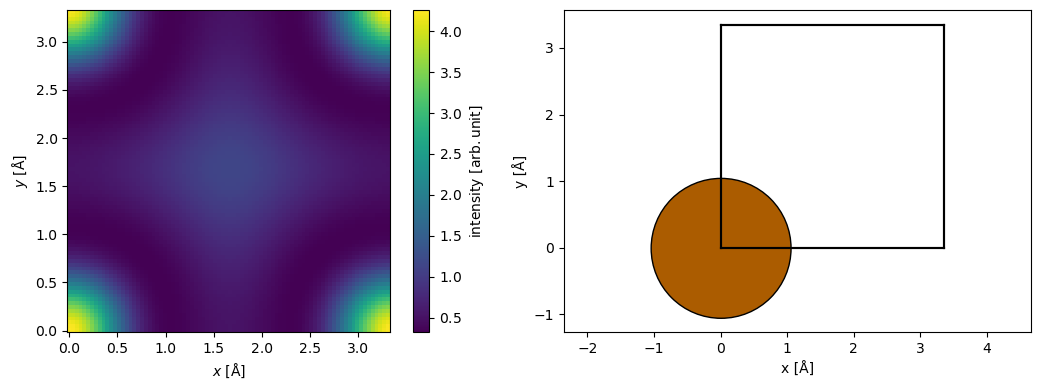

In [60]:
#- sc structure (Po) aufsetzen und diff paatt anschauen
#prep
sc_cell = ase.build.bulk("Po", crystalstructure="sc", cubic=True)#Strukturen Po mit sc, Al mit fcc, Fe mit bcc
sc_structure = sc_cell*(1,1,30)
potential_sc = abtem.Potential(sc_structure, slice_thickness=4.08 / 2, sampling=0.04)# simulation cell now has a size of 4.08 x 4.08 x 122.4 A (~12 nm hoch)
plane_wave_sc = abtem.PlaneWave(energy=200e3)

#applying multislice algorithm -> schneidet potential in Scheibchen; multislice method runs multisclice algorithm 
exit_wave_sc = plane_wave_sc.multislice(potential_sc)
exit_wave_sc.compute()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
exit_wave_sc.apply_ctf(defocus=-50, semiangle_cutoff=20).intensity().show(cbar=True, ax=ax1)
abtem.show_atoms(sc_structure,plane='xy', ax=ax2, scale=0.75)

plt.tight_layout()

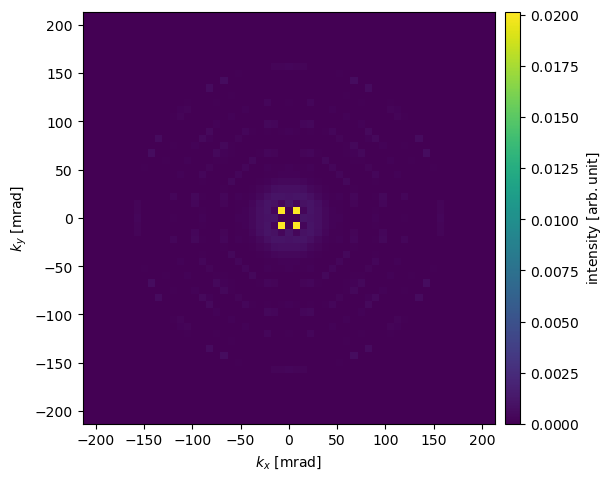

In [61]:
#check diffraction pattern
diffraction_pattern_sc = exit_wave_sc.diffraction_patterns()
diffraction_pattern_sc.block_direct().show(units="mrad", cbar=True)#block_direct() blocks direct beam - intensity to high to show on same scale

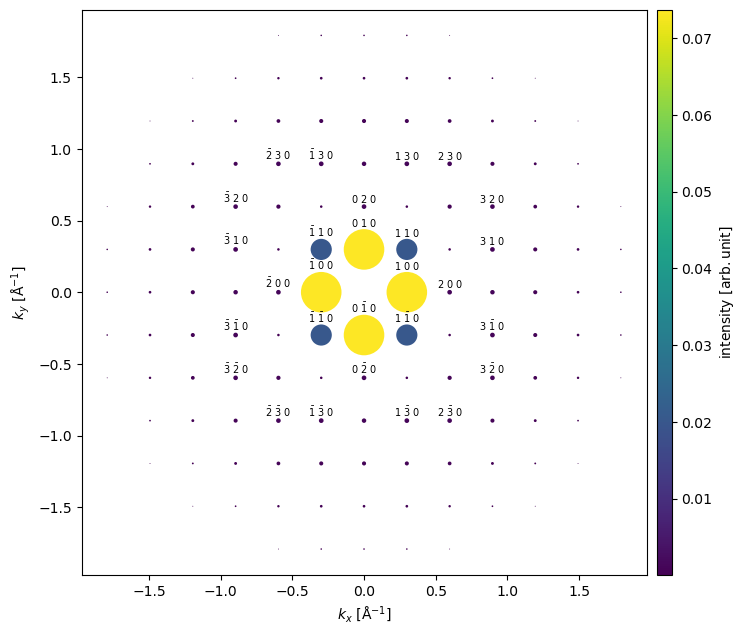

In [73]:
indexed_spots_sc = diffraction_pattern_sc.crop(50).index_diffraction_spots(cell=sc_cell)
visualization = (
    indexed_spots_sc.block_direct()
    .crop(50)
    .show(
        scale=0.02,
        cbar=True,
        annotation_kwargs={"threshold": 0.001, "fontsize": 7},
        figsize=(8, 8), 
    )
)

### Writing exit wave functions

In [ ]:
#export & import to/from zarr if needed
#exit_wave.to_zarr("./data/exit_waves.zarr", overwrite=True)
#imported_wave = abtem.from_zarr("./data/exit_waves.zarr").compute()

### Thickness series or: evolution of wave

In [86]:
#so see evolution of wave throughout the potential, we use keyword "exit_planes" of Potential-object. The keyword either takes a tupel or a single integer which denotes the stepsize
potential_series = abtem.Potential(
    atoms, slice_thickness=4.08 / 2, sampling=0.05, exit_planes=3)

exit_wave_series = plane_wave.multislice(potential_series).compute()
exit_wave_series.shape

(21, 82, 82)

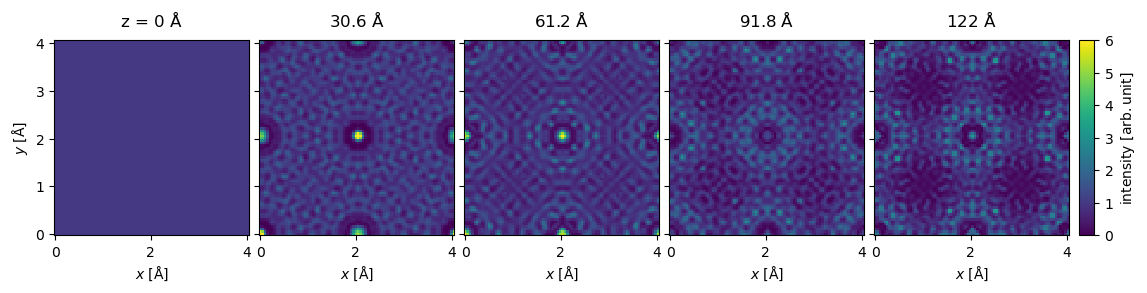

In [91]:
exit_wave_series[::5].show(
    explode=True,
    figsize=(13, 5),
    common_color_scale=True,
    cbar=True,
    vmin=0,
    vmax=6,
);

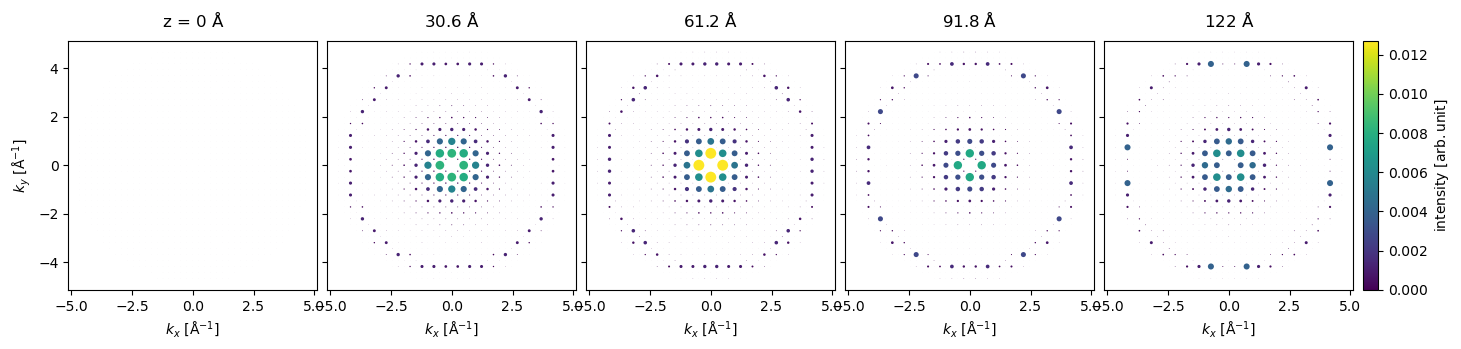

In [92]:
#related diffraction patterns
diffraction_patterns_series = exit_wave_series.diffraction_patterns(max_angle=120)
indexed_spots = diffraction_patterns_series.index_diffraction_spots(cell=4.08)

indexed_spots[::5].block_direct().show(
    explode=True,
    common_color_scale=True,
    figsize=(16, 5),
    cbar=True,
    scale=0.05,
    annotation_kwargs={"threshold": 1.0, "fontsize": 7},
);

In [96]:
df = indexed_spots.remove_low_intensity(0.005).to_dataframe()
df.iloc[::5]

hkl,0 0 0,0 2 0,0 4 0,0 -4 0,0 -2 0,2 0 0,2 2 0,...,-4 2 0,-4 -2 0,-2 0 0,-2 2 0,-2 4 0,-2 -4 0,-2 -2 0
z [Å],,,,,,,,,,,,,,,
0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30.600,0.743,0.008,0.006,0.006,0.008,0.008,0.008,...,0.004,0.004,0.008,0.008,0.004,0.004,0.008
61.200,0.712,0.013,0.005,0.005,0.013,0.013,0.006,...,0.004,0.004,0.013,0.006,0.004,0.004,0.006
91.800,0.720,0.008,0.003,0.003,0.008,0.008,0.003,...,0.002,0.002,0.008,0.003,0.002,0.002,0.003
122.400,0.629,0.004,0.004,0.004,0.004,0.004,0.006,...,0.004,0.004,0.004,0.006,0.004,0.004,0.006


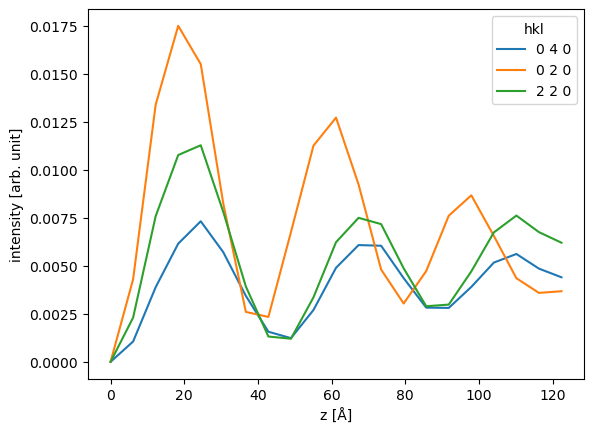

In [97]:
ax = df[["0 4 0", "0 2 0", "2 2 0"]].plot()
ax.set_ylabel("intensity [arb. unit]");

# Same fun with probe

### Multislicing - errors: self-interaction&probe placement

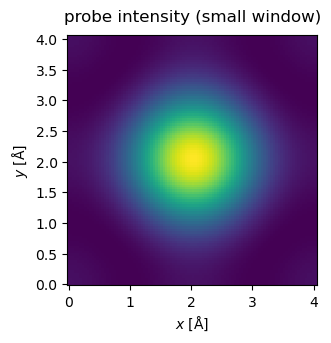

In [104]:
#create focused electron probe
multi_probe = abtem.Probe(energy=100e3, semiangle_cutoff=9)

#There are two additional considerations to take into account when performing multislice simulations with probes: 
#self-interaction errors and probe placement.

#first, match probe grid to potential grid
multi_probe.grid.match(potential)
waves_mp = multi_probe.build().compute()

#we see self interaction, f.e. because of non-circular symmetry in picture (although nothin asymmetric defined)
#self-interaction happens when the probe overlaps with its periodic images
waves_mp.show(title="probe intensity (small window)", figsize=(3,3))

"We get rid of self-interaction by increasing the extent of the potential until the probe intensity is sufficiently small at the boundary. Note that this should be true at any slice of the potential when running the multislice algorithm." [https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/multislice.html]

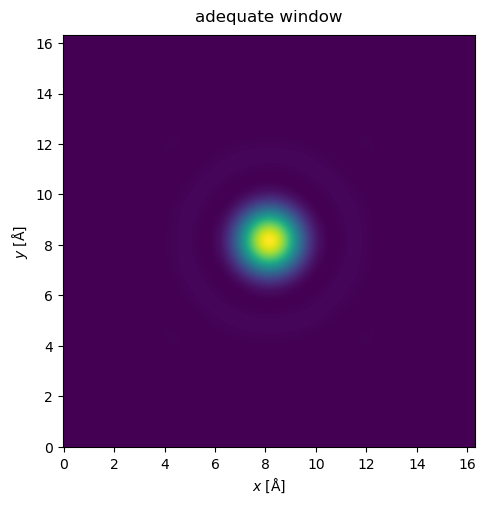

In [110]:
#SOLUTION: extend potential either by tiling up atoms or...
potential_extended = abtem.CrystalPotential(potential, (4,4,1))
multi_probe.grid.match(potential_extended)

waves_mp = multi_probe.build().compute()

#plot
waves_mp.show(title='adequate window')

In [119]:
#probe displacement 
#preperations - creating positions around center
center = (potential_extended.extent[0] / 2, potential_extended.extent[1] / 2)
displacements = [[i*0.501, 0] for i in range(10)]
#displacements = np.array([[0, 0], [0.501, 0], [1.02, 0]])
positions = center + np.array(displacements)
positions

array([[ 8.16 ,  8.16 ],
       [ 8.661,  8.16 ],
       [ 9.162,  8.16 ],
       [ 9.663,  8.16 ],
       [10.164,  8.16 ],
       [10.665,  8.16 ],
       [11.166,  8.16 ],
       [11.667,  8.16 ],
       [12.168,  8.16 ],
       [12.669,  8.16 ]])

In [120]:
exit_wave_positioned = multi_probe.multislice(scan=positions, potential=potential_extended)
exit_wave_positioned.compute()

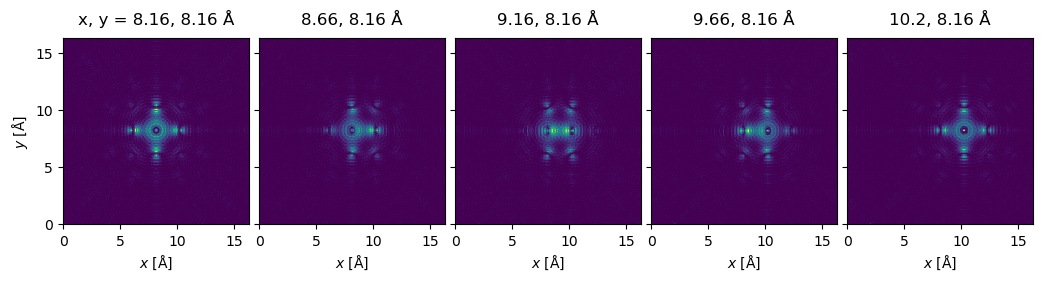

In [125]:
exit_wave_positioned[:5:].show(explode=True, figsize=(11,6))

other electron diffraction method:\
CBED - convergent beam diffraction as opposed to the SAD - selected area diffraction (above), see:\
https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/multislice.html#convergent-beam-diffraction
\
\
also possible:\
beam-tilting by very small angles, see: \
https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/multislice.html#small-angle-beam-tilt